<a href="https://colab.research.google.com/github/fatisa2000/pr/blob/main/Code_MMASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of data extraction and analysis on MMSAH dataset

## Import Library

In [2]:
!pip install win-unicode-console

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for win-unicode-console: filename=win_unicode_console-0.5-py3-none-any.whl size=20172 sha256=0cbfc8aa82400936356a1daf0eb7459310d89fd71ea66ec16b2dfd174e2d7e29
  Stored in directory: /root/.cache/pip/wheels/01/90/39/480b7553719a742763eb73c7d5db9c6a8ceb54582adfdc77c6
Successfully built win-unicode-console


In [92]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import numpy
import scipy
from scipy import stats
import warnings
from datetime import datetime
import math
warnings.filterwarnings("ignore")
import win_unicode_console
from google.colab import files
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
module_path='/content/drive/MyDrive/Colab Notebooks/MMASH.zip'
sys.path.insert(0,module_path)


In [ ]:
os.getcwd()

'/content'

In [6]:
def create_dataset(users,file_name,replace_na=True):

    """
    Returns MMASH datafarame.
    Parameters
    ---------
    nn_intervals : list
        List of Normal to Normal Interval.
    Returns
    ---------
    nni_tmstp : list
        list of time intervals between first NN-interval and final NN-interval.
    """

    import pandas
    import numpy

    df_concat = pandas.DataFrame()

    for user in users:
        try:
            df = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DataPaper/%s/%s.csv'%(user,file_name))
            df['user'] = user
            df_concat = pandas.concat([df_concat,df])
        except:
            print('NO data for %s'%user)
            pass

    del df_concat['Unnamed: 0']
    df_concat = df_concat.set_index('user')

    if replace_na == True:
        df_concat = df_concat.replace(0,numpy.nan)

    return(df_concat)

In [7]:
def _create_timestamp_list(nn_intervals):
    """
    Creates corresponding time interval for all nn_intervals
    Parameters
    ---------
    nn_intervals : list
        List of Normal to Normal Interval.
    Returns
    ---------
    nni_tmstp : list
        list of time intervals between first NN-interval and final NN-interval.
    """
    # Convert in seconds
    nni_tmstp = np.cumsum(nn_intervals) / 1000

    # Force to start at 0
    return nni_tmstp - nni_tmstp[0]


def _create_interpolated_timestamp_list(nn_intervals, sampling_frequency = 7):
    """
    Creates the interpolation time used for Fourier transform's method
    Parameters
    ---------
    nn_intervals : list
        List of Normal to Normal Interval.
    sampling_frequency : int
        Frequency at which the signal is sampled.
    Returns
    ---------
    nni_interpolation_tmstp : list
        Timestamp for interpolation.
    """
    time_nni = _create_timestamp_list(nn_intervals)
    # Create timestamp for interpolation
    nni_interpolation_tmstp = np.arange(0, time_nni[-1], 1 / float(sampling_frequency))
    return nni_interpolation_tmstp

from collections import namedtuple

WELCH_METHOD = "welch"
VlfBand = namedtuple("Vlf_band", ["low", "high"])
LfBand = namedtuple("Lf_band", ["low", "high"])
HfBand = namedtuple("Hf_band", ["low", "high"])


def _get_freq_psd_from_nn_intervals(nn_intervals, method = WELCH_METHOD,
                                    sampling_frequency = 4,
                                    interpolation_method = "linear",
                                    vlf_band = VlfBand(0.003, 0.04),
                                    hf_band = HfBand(0.15, 0.40)):
    """
    Returns the frequency and power of the signal.
    Parameters
    ---------
    nn_intervals : list
        list of Normal to Normal Interval
    method : str
        Method used to calculate the psd. Choice are Welch's FFT or Lomb method.
    sampling_frequency : int
        Frequency at which the signal is sampled. Common value range from 1 Hz to 10 Hz,
        by default set to 7 Hz. No need to specify if Lomb method is used.
    interpolation_method : str
        Kind of interpolation as a string, by default "linear". No need to specify if Lomb
        method is used.
    vlf_band : tuple
        Very low frequency bands for features extraction from power spectral density.
    hf_band : tuple
        High frequency bands for features extraction from power spectral density.
    Returns
    ---------
    freq : list
        Frequency of the corresponding psd points.
    psd : list
        Power Spectral Density of the signal.
    """

    timestamp_list = _create_timestamp_list(nn_intervals)

    if method == WELCH_METHOD:
        # ---------- Interpolation of signal ---------- #
        funct = interpolate.interp1d(x=timestamp_list, y=nn_intervals, kind=interpolation_method)

        timestamps_interpolation = _create_interpolated_timestamp_list(nn_intervals, sampling_frequency)
        nni_interpolation = funct(timestamps_interpolation)

        # ---------- Remove DC Component ---------- #
        nni_normalized = nni_interpolation - np.mean(nni_interpolation)

        #  --------- Compute Power Spectral Density  --------- #
        freq, psd = signal.welch(x=nni_normalized, fs=sampling_frequency, window='hann',
                                 nfft=4096)

    elif method == LOMB_METHOD:
        freq, psd = LombScargle(timestamp_list, nn_intervals,
                                normalization='psd').autopower(minimum_frequency=vlf_band[0],
                                                               maximum_frequency=hf_band[1])
    else:
        raise ValueError("Not a valid method. Choose between 'lomb' and 'welch'")

    return freq, psd


def plot_psd(nn_intervals, method = "welch", sampling_frequency = 7,
             interpolation_method = "linear", vlf_band: namedtuple = VlfBand(0.003, 0.04),
             lf_band: namedtuple = LfBand(0.04, 0.15), hf_band: namedtuple = HfBand(0.15, 0.40),
             save_fig = False):
    """
    Function plotting the power spectral density of the NN Intervals.
    Arguments
    ---------
    nn_intervals : list
        list of Normal to Normal Interval.
    method : str
        Method used to calculate the psd. Choice are Welch's FFT (welch) or Lomb method (lomb).
    sampling_frequency : int
        frequence at which the signal is sampled. Common value range from 1 Hz to 10 Hz, by default
        set to 7 Hz. No need to specify if Lomb method is used.
    interpolation_method : str
        kind of interpolation as a string, by default "linear". No need to specify if lomb method is
        used.
    vlf_band : tuple
        Very low frequency bands for features extraction from power spectral density.
    lf_band : tuple
        Low frequency bands for features extraction from power spectral density.
    hf_band : tuple
        High frequency bands for features extraction from power spectral density.
    """

    freq, psd = _get_freq_psd_from_nn_intervals(nn_intervals=nn_intervals, method=method,
                                                sampling_frequency=sampling_frequency,
                                                interpolation_method=interpolation_method)

    # Calcul of indices between desired frequency bands
    vlf_indexes = np.logical_and(freq >= vlf_band[0], freq < vlf_band[1])
    lf_indexes = np.logical_and(freq >= lf_band[0], freq < lf_band[1])
    hf_indexes = np.logical_and(freq >= hf_band[0], freq < hf_band[1])

    frequency_band_index = [vlf_indexes, lf_indexes, hf_indexes]
    label_list = ["VLF component", "LF component", "HF component"]

    # Plot parameters
    # sns.set_style("ticks")
    fig,ax = plt.subplots(figsize=(6,4))
    plt.xlabel("Frequency (Hz)", fontsize=15)
    plt.ylabel("PSD (s2/ Hz)", fontsize=15)

    if method == "lomb":
        plt.title("Lomb's periodogram", fontsize=20)
        for band_index, label in zip(frequency_band_index, label_list):
            plt.fill_between(freq[band_index], 0, psd[band_index] / (1000 * len(psd[band_index])), label=label)
        plt.legend(prop={"size": 15}, loc="best")

    elif method == "welch":
        plt.title("FFT Spectrum : Welch's periodogram", fontsize=20)
        for band_index, label in zip(frequency_band_index, label_list):
            plt.fill_between(freq[band_index], 0, psd[band_index] / (1000 * len(psd[band_index])), label=label)
        plt.legend(prop={"size": 15}, loc="best")
        plt.xlim(0, hf_band[1])
    else:
        raise ValueError("Not a valid method. Choose between 'lomb' and 'welch'")

    fig.tight_layout()

    if save_fig == True:
        fig.savefig('psd.pdf')

    plt.show()


def plot_poincare(nn_intervals, plot_sd_features = True, save_fig = False):
    """
    Pointcare / Lorentz Plot of the NN Intervals
    Arguments
    ---------
    nn_intervals : list
        list of NN intervals
    plot_sd_features : bool
        Option to show or not SD1 and SD2 features on plot. By default, set to True.
    Notes
    ---------
    The transverse axis (T) reflects beat-to-beat variation
    the longitudinal axis (L) reflects the overall fluctuation
    """

    # For Lorentz / poincaré Plot
    ax1 = nn_intervals[:-1]
    ax2 = nn_intervals[1:]

    # compute features for ellipse's height, width and center
    dict_sd1_sd2 = get_poincare_plot_features(nn_intervals)
    sd1 = dict_sd1_sd2["sd1"]
    sd2 = dict_sd1_sd2["sd2"]
    mean_nni = np.mean(nn_intervals)

    # Plot options and settings
    # sns.set_style("ticks")
    fig,ax = plt.subplots(figsize=(6,6))
    plt.title("Poincaré Plot", fontsize=20)
    plt.xlabel('NN_n (ms)', fontsize=15)
    plt.ylabel('NN_n+1 (ms)', fontsize=15)
    plt.xlim(min(nn_intervals) - 10, max(nn_intervals) + 10)
    plt.ylim(min(nn_intervals) - 10, max(nn_intervals) + 10)
    plt.plot([0,1500],[0,1500],'--',c='k')

    # Poincaré Plot
    ax.scatter(ax1, ax2, c='b', s=20, alpha=0.4)

    if plot_sd_features:
        # Ellipse plot settings
        ells = Ellipse(xy=(mean_nni, mean_nni), width=2 * sd2 + 1,
                       height=2 * sd1 + 1, angle=45, linewidth=3, edgecolor = 'k',
                       fill=False)
        ax.add_patch(ells)

        ells = Ellipse(xy=(mean_nni, mean_nni), width=2 * sd2,
                       height=2 * sd1, angle=45)
        ells.set_alpha(0.05)
        ells.set_facecolor("blue")
        ax.add_patch(ells)

        # Arrow plot settings
        sd1_arrow = ax.arrow(mean_nni, mean_nni, -sd1 * np.sqrt(2) / 2, sd1 * np.sqrt(2) / 2,
                             linewidth=4, ec='r', fc="r", label="SD1")
        sd2_arrow = ax.arrow(mean_nni, mean_nni, sd2 * np.sqrt(2) / 2, sd2 * np.sqrt(2) / 2,
                             linewidth=4, ec='orange', fc="orange", label="SD2")

        plt.legend(handles=[sd1_arrow, sd2_arrow], fontsize=12, loc="best")

    fig.tight_layout()

    if save_fig == True:
        fig.savefig('poincare.pdf')

    plt.show()


def get_poincare_plot_features(nn_intervals):
    """
    Function returning a dictionary containing 3 features from non linear domain
    for HRV analyses.
    Known practise is to use this function on short term recordings, from 5 minutes window.
    Parameters
    ---------
    nn_intervals : list
        Normal to Normal Interval
    Returns
    ---------
    poincare_plot_features : dict
        Dictionary containing non linear domain features for hrV analyses. There
        are details about each features are given below.
    Notes
    ---------
    - **sd1** : The standard deviation of projection of the Poincaré plot on the line \
    perpendicular to the line of identity.
    - **sd2** : SD2 is defined as the standard deviation of the projection of the Poincaré \
    plot on the line of identity (y=x).
    - **ratio_sd2_sd1** : Ratio between SD2 and SD1.
    References
    ----------
    .. [4] Pre-ictal heart rate variability assessment of epileptic seizures by means of linear \
    and non- linear analyses, Soroor Behbahani, Nader Jafarnia Dabanloo et al - 2013
    """
    diff_nn_intervals = np.diff(nn_intervals)
    # measures the width of poincare cloud
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    # measures the length of the poincare cloud
    sd2 = np.sqrt(2 * np.std(nn_intervals, ddof=1) ** 2 - 0.5 * np.std(diff_nn_intervals, ddof=1) ** 2)
    ratio_sd2_sd1 = sd2 / sd1

    poincare_plot_features = {
        'sd1': sd1,
        'sd2': sd2,
        'ratio_sd2_sd1': ratio_sd2_sd1
    }

    return poincare_plot_features


def get_time_domain_features(nn_intervals):
    """
    Returns a dictionary containing time domain features for HRV analysis.
    Mostly used on long term recordings (24h) but some studies use some of those features on
    short term recordings, from 1 to 5 minutes window.
    Parameters
    ----------
    nn_intervals : list
        list of Normal to Normal Interval
    Returns
    -------
    time_domain_features : dict
        dictionary containing time domain features for HRV analyses. There are details
        about each features below.
    Notes
    -----
    Here are some details about feature engineering...
    - **mean_nni**: The mean of RR-intervals.
    - **sdnn** : The standard deviation of the time interval between successive normal heart beats \
    (i.e. the RR-intervals).
    - **sdsd**: The standard deviation of differences between adjacent RR-intervals
    - **rmssd**: The square root of the mean of the sum of the squares of differences between \
    adjacent NN-intervals. Reflects high frequency (fast or parasympathetic) influences on hrV \
    (*i.e.*, those influencing larger changes from one beat to the next).
    - **median_nni**: Median Absolute values of the successive differences between the RR-intervals.
    - **nni_50**: Number of interval differences of successive RR-intervals greater than 50 ms.
    - **pnni_50**: The proportion derived by dividing nni_50 (The number of interval differences \
    of successive RR-intervals greater than 50 ms) by the total number of RR-intervals.
    - **nni_20**: Number of interval differences of successive RR-intervals greater than 20 ms.
    - **pnni_20**: The proportion derived by dividing nni_20 (The number of interval differences \
    of successive RR-intervals greater than 20 ms) by the total number of RR-intervals.
    - **range_nni**: difference between the maximum and minimum nn_interval.
    - **cvsd**: Coefficient of variation of successive differences equal to the rmssd divided by \
    mean_nni.
    - **cvnni**: Coefficient of variation equal to the ratio of sdnn divided by mean_nni.
    - **mean_hr**: The mean Heart Rate.
    - **max_hr**: Max heart rate.
    - **min_hr**: Min heart rate.
    - **std_hr**: Standard deviation of heart rate.
    References
    ----------
    .. [1] Heart rate variability - Standards of measurement, physiological interpretation, and \
    clinical use, Task Force of The European Society of Cardiology and The North American Society \
    of Pacing and Electrophysiology, 1996
    """

    diff_nni = np.diff(nn_intervals)
    length_int = len(nn_intervals)

    # Basic statistics
    mean_nni = np.mean(nn_intervals)
    median_nni = np.median(nn_intervals)
    range_nni = max(nn_intervals) - min(nn_intervals)

    sdsd = np.std(diff_nni)
    rmssd = np.sqrt(np.mean(diff_nni ** 2))

    nni_50 = sum(np.abs(diff_nni) > 50)
    pnni_50 = 100 * nni_50 / length_int


    # Features only for long term recordings
    sdnn = np.std(nn_intervals, ddof=1)  # ddof = 1 : unbiased estimator => divide std by n-1

    # Heart Rate equivalent features
    heart_rate_list = np.divide(60000, nn_intervals)
    mean_hr = np.mean(heart_rate_list)
    min_hr = min(heart_rate_list)
    max_hr = max(heart_rate_list)
    std_hr = np.std(heart_rate_list)

    time_domain_features = {
        'mean_nni': mean_nni,
        'sdnn': sdnn,
        'pnni_50': pnni_50,
        'rmssd': rmssd,
        'median_nni': median_nni,
        'range_nni': range_nni,
        'mean_hr': mean_hr,
        "max_hr": max_hr,
        "min_hr": min_hr,
        "std_hr": std_hr,
    }

    return time_domain_features


def get_frequency_domain_features(nn_intervals, method = WELCH_METHOD,
                                  sampling_frequency = 4, interpolation_method = "linear",
                                  vlf_band = VlfBand(0.003, 0.04),
                                  lf_band = LfBand(0.04, 0.15),
                                  hf_band = HfBand(0.15, 0.40)):
    """
    Returns a dictionary containing frequency domain features for HRV analyses.
    To our knowledge, you might use this function on short term recordings, from 2 to 5 minutes  \
    window.
    Parameters
    ---------
    nn_intervals : list
        list of Normal to Normal Interval
    method : str
        Method used to calculate the psd. Choice are Welch's FFT or Lomb method.
    sampling_frequency : int
        Frequency at which the signal is sampled. Common value range from 1 Hz to 10 Hz,
        by default set to 4 Hz. No need to specify if Lomb method is used.
    interpolation_method : str
        kind of interpolation as a string, by default "linear". No need to specify if Lomb
        method is used.
    vlf_band : tuple
        Very low frequency bands for features extraction from power spectral density.
    lf_band : tuple
        Low frequency bands for features extraction from power spectral density.
    hf_band : tuple
        High frequency bands for features extraction from power spectral density.
    Returns
    ---------
    frequency_domain_features : dict
        Dictionary containing frequency domain features for HRV analyses. There are details
        about each features below.
    Notes
    ---------
    Details about feature engineering...
    - **total_power** : Total power density spectral
    - **vlf** : variance ( = power ) in HRV in the Very low Frequency (.003 to .04 Hz by default). \
    Reflect an intrinsic rhythm produced by the heart which is modulated primarily by sympathetic \
    activity.
    - **lf** : variance ( = power ) in HRV in the low Frequency (.04 to .15 Hz). Reflects a \
    mixture of sympathetic and parasympathetic activity, but in long-term recordings, it reflects \
    sympathetic activity and can be reduced by the beta-adrenergic antagonist propanolol.
    - **hf**: variance ( = power ) in HRV in the High Frequency (.15 to .40 Hz by default). \
    Reflects fast changes in beat-to-beat variability due to parasympathetic (vagal) activity. \
    Sometimes called the respiratory band because it corresponds to HRV changes related to the \
    respiratory cycle and can be increased by slow, deep breathing (about 6 or 7 breaths per \
    minute) and decreased by anticholinergic drugs or vagal blockade.
    - **lf_hf_ratio** : lf/hf ratio is sometimes used by some investigators as a quantitative \
    mirror of the sympatho/vagal balance.
    - **lfnu** : normalized lf power.
    - **hfnu** : normalized hf power.
    References
    ----------
    .. [1] Heart rate variability - Standards of measurement, physiological interpretation, and \
    clinical use, Task Force of The European Society of Cardiology and The North American Society \
    of Pacing and Electrophysiology, 1996
    .. [2] Signal Processing Methods for Heart Rate Variability - Gari D. Clifford, 2002
    """

    # ----------  Compute frequency & Power spectral density of signal  ---------- #
    freq, psd = _get_freq_psd_from_nn_intervals(nn_intervals=nn_intervals, method=method,
                                                sampling_frequency=sampling_frequency,
                                                interpolation_method=interpolation_method,
                                                vlf_band=vlf_band, hf_band=hf_band)

    # ---------- Features calculation ---------- #
    freqency_domain_features = _get_features_from_psd(freq=freq, psd=psd,
                                                      vlf_band=vlf_band,
                                                      lf_band=lf_band,
                                                      hf_band=hf_band)

    return freqency_domain_features


def _get_features_from_psd(freq, psd,
                           vlf_band = VlfBand(0.003, 0.04),
                           lf_band = LfBand(0.04, 0.15),
                           hf_band = HfBand(0.15, 0.40)):
    """
    Computes frequency domain features from the power spectral decomposition.
    Parameters
    ---------
    freq : array
        Array of sample frequencies.
    psd : list
        Power spectral density or power spectrum.
    vlf_band : tuple
        Very low frequency bands for features extraction from power spectral density.
    lf_band : tuple
        Low frequency bands for features extraction from power spectral density.
    hf_band : tuple
        High frequency bands for features extraction from power spectral density.
    Returns
    ---------
    freqency_domain_features : dict
        Dictionary containing frequency domain features for HRV analyses. There are details
        about each features given below.
    """

    # Calcul of indices between desired frequency bands
    vlf_indexes = np.logical_and(freq >= vlf_band[0], freq < vlf_band[1])
    lf_indexes = np.logical_and(freq >= lf_band[0], freq < lf_band[1])
    hf_indexes = np.logical_and(freq >= hf_band[0], freq < hf_band[1])

    # Integrate using the composite trapezoidal rule
    lf = np.trapz(y=psd[lf_indexes], x=freq[lf_indexes])
    hf = np.trapz(y=psd[hf_indexes], x=freq[hf_indexes])

    # total power & vlf : Feature often used for  "long term recordings" analysis
    vlf = np.trapz(y=psd[vlf_indexes], x=freq[vlf_indexes])
    total_power = vlf + lf + hf

    lf_hf_ratio = lf / hf
    lfnu = (lf / (lf + hf)) * 100
    hfnu = (hf / (lf + hf)) * 100

    freqency_domain_features = {
        'lf': lf,
        'hf': hf,
        'lf_hf_ratio': lf_hf_ratio,
        'lfnu': lfnu,
        'hfnu': hfnu,
        'total_power': total_power,
        'vlf': vlf
    }

    return freqency_domain_features

def plot_HRV(df_window):

    """
    Returns Poincarrè plot and spectral analysis plot
    """
    # DRAW PLOTS
    fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1,figsize=(10,7))

    # POINCARè PLOT
    nn_intervals = list(1000*df_window['ibi_s'].dropna().values)
    val1 = nn_intervals[:-1]
    val2 = nn_intervals[1:]

    # compute features for ellipse's height, width and center
    dict_sd1_sd2 = get_poincare_plot_features(nn_intervals)
    sd1 = dict_sd1_sd2["sd1"]
    sd2 = dict_sd1_sd2["sd2"]
    mean_nni = np.mean(nn_intervals)

    ax1.scatter(val1, val2, c='b', s=20, alpha=0.4)

    ells = Ellipse(xy=(mean_nni, mean_nni), width=2 * sd2 + 1,
            height=2 * sd1 + 1, angle=45, linewidth=3, edgecolor = 'k',
            fill=False)
    ax1.add_patch(ells)

    ells = Ellipse(xy=(mean_nni, mean_nni), width=2 * sd2,
                    height=2 * sd1, angle=45)
    ells.set_alpha(0.05)
    ells.set_facecolor("blue")
    ax1.add_patch(ells)

    # Arrow plot settings
    sd1_arrow = ax1.arrow(mean_nni, mean_nni, -sd1 * np.sqrt(2) / 2, sd1 * np.sqrt(2) / 2,
                          linewidth=4, ec='r', fc="r", label="SD1")
    sd2_arrow = ax1.arrow(mean_nni, mean_nni, sd2 * np.sqrt(2) / 2, sd2 * np.sqrt(2) / 2,
                          linewidth=4, ec='orange', fc="orange", label="SD2")

    ax1.plot([np.min(nn_intervals)-20,np.max(nn_intervals)+20],[np.min(nn_intervals)-20,np.max(nn_intervals)+20],'k--')
    ax1.legend(handles=[sd1_arrow, sd2_arrow], fontsize=12, loc="best")

    ax1.set_title("Poincaré Plot", fontsize=20)
    ax1.set_xlabel('NN_n (ms)', fontsize=15)
    ax1.set_ylabel('NN_n+1 (ms)', fontsize=15)


    # PSD PLOT
    VlfBand = namedtuple("Vlf_band", ["low", "high"])
    LfBand = namedtuple("Lf_band", ["low", "high"])
    HfBand = namedtuple("Hf_band", ["low", "high"])

    vlf_band = VlfBand(0.003, 0.04)
    lf_band = LfBand(0.04, 0.15)
    hf_band = HfBand(0.15, 0.40)

    freq, psd = _get_freq_psd_from_nn_intervals(nn_intervals=nn_intervals, method = "welch", sampling_frequency = 7,
                                                    interpolation_method = "linear")

    # Calcul of indices between desired frequency bands
    vlf_indexes = np.logical_and(freq >= vlf_band[0], freq < vlf_band[1])
    lf_indexes = np.logical_and(freq >= lf_band[0], freq < lf_band[1])
    hf_indexes = np.logical_and(freq >= hf_band[0], freq < hf_band[1])

    frequency_band_index = [vlf_indexes, lf_indexes, hf_indexes]
    label_list = ["VLF component", "LF component", "HF component"]

    # Plot parameters
    # sns.set_style("ticks")
    ax2.set_xlabel("Frequency (Hz)", fontsize=15)
    ax2.set_ylabel("PSD (s2/ Hz)", fontsize=15)

    ax2.set_title("FFT Spectrum", fontsize=20) # Welch's periodogram
    for band_index, label in zip(frequency_band_index, label_list):
        ax2.fill_between(freq[band_index], 0, psd[band_index] / (1000 * len(psd[band_index])), label=label)
    ax2.legend(prop={"size": 12}, loc="best")
    ax2.set_xlim(0, hf_band[1])

    fig.tight_layout()
    plt.show()

In [8]:
def fit_sin(tt, yy,plot=False):

    '''
    Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period"
    Parameters
    ---------
    tt : list
        List of timestamp expressed in seconds
    yy: list
        List of values to fit circadian rhythm (e.g., Heart Rate, intra-beats intervals).
    Returns
    ---------
    res : dictionaire
        dictionaires cotaining fitting parmeters.
    '''

    import scipy
    import numpy
    from sklearn.metrics import r2_score
    import pandas as pd
    import matplotlib.pyplot as plt

    tt = numpy.array(tt)
    yy = numpy.array(yy)
    freq = 24*3600 # dayly frequency (24h in seconds)
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return  A * numpy.sin((t/(freq))*2*numpy.pi + p) + c

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)

    fitfunc = lambda t: A * numpy.sin((t/freq)*2*numpy.pi + p) + c

    coefficient_of_dermination = r2_score(yy, fitfunc(tt))
    acrophase_time = pd.DataFrame([[x,y] for x,y in zip(tt,fitfunc(tt))],columns=['t','val']).set_index('t')
    acrophase_timestamp = acrophase_time[acrophase_time.val == acrophase_time.max().values[0]].index[0]

    res = {"amp": abs(A), "phase": p, "APhase": acrophase_timestamp, "offset": c, "r2":coefficient_of_dermination,"tt":tt,'ff':fitfunc(tt)}

    if plot==True:
        fig,ax = plt.subplots(figsize=(6,5))
        ax.plot(tt, yy, "-k", linewidth=1, alpha=0.3)
        ax.plot(tt, fitfunc(tt), "r-", label="circadian rhythm", linewidth=1)
        plt.xticks(numpy.arange(130000)[::20000][2:],['11AM day 1','5:30PM day 1','10PM day 1', '3:30AM day 2', '9AM day 2'],rotation=90)
        plt.legend()
        fig.tight_layout()
        plt.show()

    return res

## Download dataset

In [ ]:
!pip install wfdb
import wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install wget
!wget -r -N -c -np https://physionet.org/files/mmash/1.0.0/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=f52dc03ee50e270db0387a3d8969bdc1de01166262c001f6ee9972db27cfc31c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2023-06-14 15:35:55--  https://physionet.org/files/mmash/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/mmash/1.0.0/index.html’

physionet.org/files     [ <=>                ]     560  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-06-14 15:35:55 (44.3 MB/s) - ‘physionet.org/files/mmash/1.0.0/index.html’ saved [560]

Loading robots.txt; pleas

In [ ]:
import os
url = 'https://physionet.org/files/mmash/1.0.0/'
os.system("""wget -r -N -c -np https://physionet.org/files/mmash/1.0.0/""")

0

## Analysis

In [9]:
path = '/content/drive/MyDrive/Colab Notebooks/data/DataPaper' # Select the path where the data are allocated

users = os.listdir(path)[:-1] # Cerate a list of users' name

### Antropometric characteristics

In [10]:
df_antro =create_dataset(users,'user_info') # Import dataset with antropometric characteristics

In [11]:
df_antro.describe().T # Descriptive statistics

,count,mean,std,min,25%,50%,75%,max
Weight,21.0,74.809524,13.056106,60.0,67.0,70.0,80.00,115.0
Height,21.0,179.904762,8.419648,169.0,175.0,180.0,183.00,205.0
Age,20.0,27.450000,4.248529,20.0,25.0,27.0,28.25,40.0


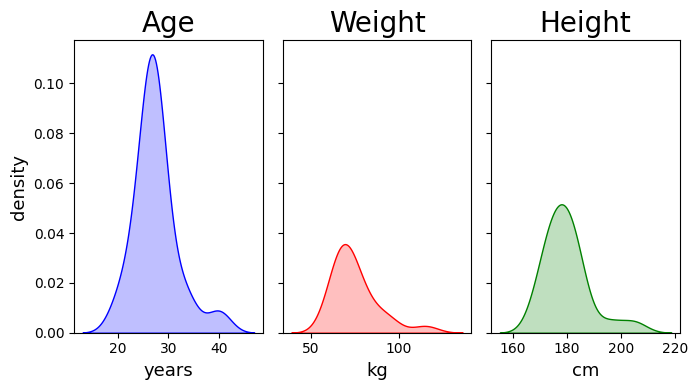

In [12]:
# Density plot of the users' antropometric characteristic distributions

f,ax = plt.subplots(1,3,figsize=(7,4),sharey=True)

for col,i,xlabel,color in zip(['Age','Weight','Height'],list(range(3)),['years','kg','cm'],['b','r','g']):
    sns.kdeplot(df_antro[col], ax=ax[i], color=color, shade=True)
    ax[i].set_title(col,fontsize=20)
    ax[i].set_xlabel(xlabel,fontsize=13)
    ax[i].legend().set_visible(False)

ax[0].set_ylabel('density',fontsize=13)

f.tight_layout()
plt.show()

### Questionnaire

In [13]:
df_question = create_dataset(users,'questionnaire') # Import dataset with questionnaire data

In [14]:
df_question.describe().T # Descriptive statistics

,count,mean,std,min,25%,50%,75%,max
MEQ,21.0,49.952381,6.981950,38.0,45.00,49.0,55.00,64.0
STAI1,21.0,34.857143,7.669979,24.0,29.00,33.0,39.00,54.0
STAI2,20.0,41.350000,5.556172,27.0,39.00,42.5,45.25,49.0
Pittsburgh,21.0,5.333333,2.033060,2.0,4.00,5.0,7.00,9.0
Daily_stress,21.0,32.047619,16.686750,10.0,22.00,30.0,41.00,74.0
BISBAS_bis,21.0,22.190476,2.441701,19.0,20.00,22.0,24.00,26.0
BISBAS_reward,21.0,19.285714,2.411283,14.0,18.00,19.0,21.00,24.0
BISBAS_drive,21.0,12.047619,1.935877,8.0,11.00,12.0,14.00,16.0
BISBAS_fun,21.0,10.571429,3.264528,5.0,8.00,11.0,13.00,15.0
panas_pos_10,21.0,27.238095,4.805255,21.0,23.00,28.0,30.00,37.0


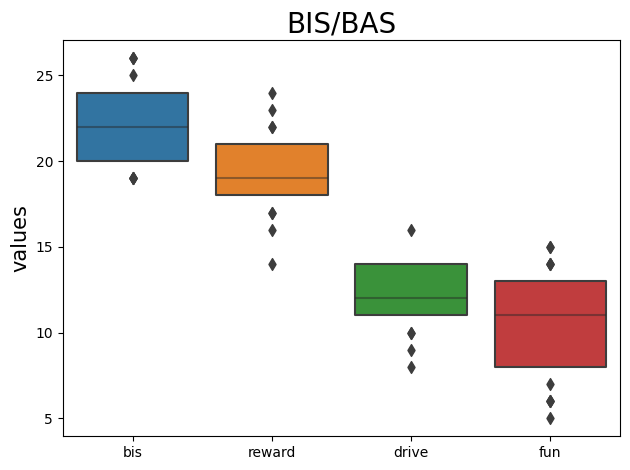

In [15]:
# Boxplot BIS/BAS for each component

df_group_BISBAS = pd.DataFrame()
for col in ['BISBAS_bis','BISBAS_reward','BISBAS_drive','BISBAS_fun']:
    df_BISBAS = pd.DataFrame(df_question[col]).rename(columns={col:'BISBAS'})
    df_BISBAS['var'] = col
    df_group_BISBAS = pd.concat([df_group_BISBAS,df_BISBAS])

f,ax = plt.subplots()
sns.boxenplot(data=df_group_BISBAS,x='var',y='BISBAS', ax=ax)
plt.xticks(list(range(4)),['bis','reward','drive','fun'])
ax.set_xlabel('')
ax.set_ylabel('values',fontsize=15)
ax.set_title('BIS/BAS',fontsize=20)
f.tight_layout()
plt.show()

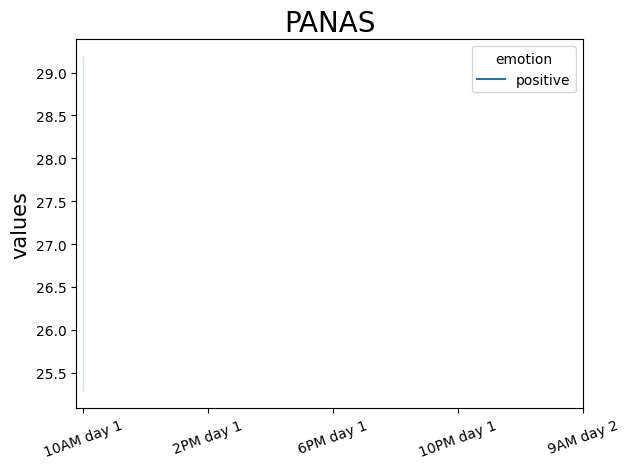

In [16]:
# Daily evolution of Positive and Negative emotions (PANAS)

df_group_Panas = pd.DataFrame()
for col in ['panas_pos_10','panas_pos_14','panas_pos_18','panas_pos_22','panas_pos_9+1']:
    df_PANAS = pd.DataFrame(df_question[col]).rename(columns={col:'PANAS'})
    df_PANAS['var'] = col
    df_PANAS['emotion'] = 'positive'
    df_group_Panas = pd.concat([df_group_Panas,df_PANAS])

for col in ['panas_neg_10','panas_neg_14','panas_neg_18','panas_neg_22','panas_neg_9+1']:
    df_PANAS = pd.DataFrame(df_question[col]).rename(columns={col:'PANAS'})
    df_PANAS['var'] = col
    df_PANAS['emotion'] = 'negative'
    df_group_Panas = pd.concat([df_group_Panas,df_PANAS])

df_group_Panas = df_group_Panas.replace({'panas_pos_10':'1_10AM day 1','panas_pos_14':'2_2PM day 1','panas_pos_18':'3_6PM day 1','panas_pos_22':'4_10PM day 1','panas_pos_9+1':'5_9AM day 2',
                                         'panas_neg_10':'1_10AM day 1','panas_neg_14':'2_2PM day 1','panas_neg_18':'3_6PM day 1','panas_neg_22':'4_10PM day 1','panas_neg_9+1':'5_9AM day 2'})

f,ax = plt.subplots()
df_group_Panas=df_group_Panas.loc[~df_group_Panas.index.duplicated(), :]
sns.lineplot(data=df_group_Panas,x="var", y="PANAS", hue='emotion')
plt.xticks(list(range(5)),['10AM day 1', '2PM day 1', '6PM day 1', '10PM day 1', '9AM day 2'], rotation = 20)
ax.set_xlabel('')
ax.set_ylabel('values',fontsize=15)
ax.set_title('PANAS',fontsize=20)
f.tight_layout()
plt.show()

### Sleep

In [17]:
df_sleep =create_dataset(users,'sleep') # Import dataset with questionnaire data


In [220]:
# Transform Time format in seconds. 0 refers to 12 AM, while positive and negative values refers to pre and post midnight, respectively.
#df_sleep['In Bed Time'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_sleep['In Bed Time']]
#df_sleep['In Bed Time'] = [x-24*60 if x>20*60 else x for x in df_sleep['In Bed Time']]

#df_sleep['Out Bed Time'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_sleep['Out Bed Time']]
#df_sleep['Out Bed Time'] = [x-24*60 if x>20*60 else x  for x in df_sleep['Out Bed Time']]

#df_sleep['Onset Time'] = [int(x.split(':')[0])*60+int(x.split(':')[1])for x in df_sleep['Onset Time']]
#df_sleep['Onset Time'] = [x-24*60 if x>20*60 else x  for x in df_sleep['Onset Time']]

#df_sleep = df_sleep.fillna(0)

In [18]:
df_sleep.describe().T # Descriptive statistics

,count,mean,std,min,25%,50%,75%,max
In Bed Date,21.0,1.809524,0.402374,1.000,2.000,2.000,2.000,2.000
In Bed Time,21.0,48.714286,74.267855,-91.000,17.000,44.000,63.000,237.000
Out Bed Date,21.0,1.809524,0.402374,1.000,2.000,2.000,2.000,2.000
Out Bed Time,21.0,428.285714,88.331276,211.000,396.000,424.000,478.000,660.000
Onset Date,21.0,1.809524,0.402374,1.000,2.000,2.000,2.000,2.000
Onset Time,21.0,50.238095,74.129552,-88.000,20.000,44.000,63.000,237.000
Latency,21.0,1.523810,1.749830,0.000,0.000,0.000,3.000,4.000
Efficiency,21.0,83.645714,6.797943,73.490,76.470,84.920,88.070,94.230
Total Minutes in Bed,21.0,379.571429,95.270442,165.000,332.000,373.000,436.000,630.000
Total Sleep Time (TST),21.0,316.666667,84.575016,144.000,273.000,333.000,343.000,578.000


TypeError: ignored

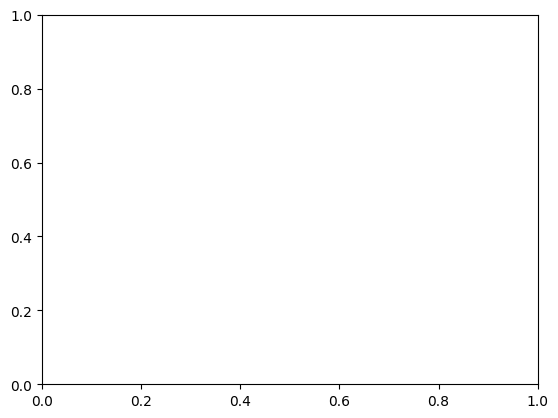

In [18]:
# Density plot of "In bed time" and "Out of bad time" distributions

f,ax = plt.subplots()
sns.kdeplot(df_sleep['In Bed Time'], color='darkblue', shade=True, linestyle='-', lw=2)
sns.kdeplot(df_sleep['Out Bed Time'], color='darkgreen', shade=True, linestyle='-', lw=2)
ax.set_title('Time in bed',fontsize=20)
ax.set_ylabel('density',fontsize=15)
ax.set_xlabel('hour of the day',fontsize=15)
plt.xticks(list(range(-200,800,200)),['10PM','12AM','3AM','6AM','9AM'])
f.tight_layout()
plt.show()

### Activity

In [19]:
df_activity =create_dataset(users,'Activity',replace_na=False) # Import dataset with Activity diary data

In [20]:
# Create dict to map activity reported by users in the activity diary
dict_activity = {0: 'sleeping',
                 1: 'laying down',
                 2: 'sitting',
                 3: 'light movement',
                 4: 'medium movement',
                 5: 'heavy movement',
                 6: 'eating',
                 7: 'small screen usage',
                 8: 'large screen',
                 9: 'coffee/coke',
                 10: 'smoking',
                 11: 'alcohol assumption',
                 12: 'saliva samples'}

df_activity['Activity'] = df_activity['Activity'].replace(dict_activity) # maping activity

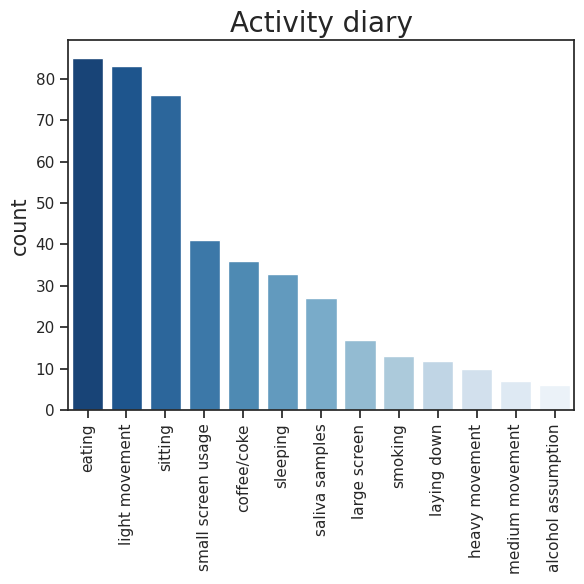

In [21]:
df_activity_count = pd.DataFrame(Counter(df_activity['Activity']).items(),columns=['Activity','count']) # Create pandas DataFrame with actifity count

# Barplot of activity counter
sns.set(style="ticks")
f,ax = plt.subplots(figsize=(6,6))
df_activity_count = df_activity_count.sort_values('count',ascending=False)
sns.barplot(data=df_activity_count,x='Activity',y='count',palette='Blues_r')
plt.xlabel('')
plt.ylabel('count',fontsize=15)
plt.title('Activity diary',fontsize=20)
plt.xticks(rotation=90)
f.tight_layout()
plt.show()

### Actigraph

In [22]:
df_actigraph =create_dataset(users,'Actigraph') # Import dataset with actigraph data

In [23]:
df_actigraph.describe().T # Descriptive statistics

,count,mean,std,min,25%,50%,75%,max
Axis1,446545.0,50.610521,51.660519,1.0,15.00,36.00,68.00,910.00
Axis2,399599.0,57.505797,60.417813,1.0,17.00,41.00,76.00,797.00
Axis3,468661.0,56.979608,54.223925,1.0,18.00,41.00,79.00,919.00
Steps,226130.0,1.123000,0.360126,1.0,1.00,1.00,1.00,4.00
HR,1391633.0,74.701010,16.570873,3.0,63.00,73.00,84.00,251.00
Inclinometer Off,317228.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
Inclinometer Standing,454398.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
Inclinometer Sitting,428076.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
Inclinometer Lying,191931.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
Vector Magnitude,528439.0,90.389995,83.650068,1.0,28.84,70.23,125.36,1017.89


### RR-intervals

In [24]:
df_rr =create_dataset(users,'RR').reset_index() # Import dataset with RR intervals data

In [25]:
# Transform Time format in seconds. 0 refers to 12 AM, while positive and negative values refers to pre and post midnight, respectively.
df_rr['timestamp'] = [float(x.split(':')[0])*60*60 + float(x.split(':')[1])*60 + float(x.split(':')[2]) if y==1 else
                        float(x.split(':')[0])*60*60 + float(x.split(':')[1])*60 + float(x.split(':')[2]) + 24*60*60
                        for x,y in zip(df_rr['time'],df_rr['day'])]

# Fiter ectopic beats
df_rr['ibi_s'] = [x if x<2 else np.nan for x in df_rr['ibi_s']]
df_rr['ibi_s'] = [x if x>0.3 else np.nan for x in df_rr['ibi_s']]
# df_rr = df_rr.dropna()

# Compute Heart Rate values from ibi
df_rr['hr'] = [60/x for x in df_rr['ibi_s']]

In [26]:
print(df_rr['hr'])

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
1646950    92.735703
1646951    93.896714
1646952    93.023256
1646953    89.955022
1646954    95.389507
Name: hr, Length: 1646955, dtype: float64


In [27]:
df_rr[['ibi_s','hr']].describe().T.round(2) # Descriptive statistics

,count,mean,std,min,25%,50%,75%,max
ibi_s,1641381.0,0.81,0.19,0.30,0.68,0.80,0.93,2.00
hr,1641381.0,78.04,19.75,30.02,64.66,75.47,87.98,199.34


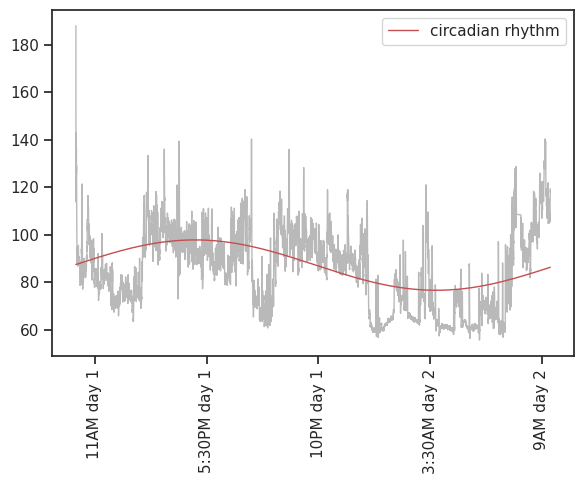

{'amp': 10.602767810093868, 'phase': 0.5003862366359169, 'APhase': 57919.0, 'offset': 87.28893549260567, 'r2': 0.20674833281421934, 'tt': array([ 36618.,  36618.,  36619., ..., 121525., 121525., 121526.]), 'ff': array([87.51931221, 87.51931221, 87.52008308, ..., 86.36930216,
       86.36930216, 86.37007032])}


In [28]:
df_user_example = df_rr[df_rr['user']=='user_1'].dropna()
res_single =fit_sin(df_user_example['timestamp'],df_user_example['hr'].rolling(60,min_periods=1).mean(),plot=True) # fit single component cosinor curves
print(res_single)

In [29]:
# Single component cosinor analysis
results = {}

for user in users:
    df_user = df_rr[df_rr['user']==user].dropna()
    results[user] = fit_sin(df_user['timestamp'],df_user['hr'],plot=False)

df_circadian = pd.DataFrame(results)

In [30]:
df_circadian.T[['amp','phase','offset','r2']].astype(float).describe() # Descriptive statistics

,amp,phase,offset,r2
count,21.000000,21.000000,21.000000,21.000000
mean,11.913447,0.323912,76.239796,0.237584
std,6.651223,0.781153,5.973752,0.161656
min,1.039398,-1.654571,65.975072,0.001986
25%,7.905381,0.118605,72.567970,0.095833
50%,11.870312,0.554353,75.972583,0.193091
75%,14.307344,0.785946,77.761897,0.322181
max,32.205859,1.340508,88.049187,0.526205


#### HRV analysis example

In [49]:
# select a 5 minutes time window for HRV analysis
df_user["window"] = df_user.timestamp.diff().dropna().cumsum().pipe(lambda x: pd.to_timedelta(x, "s")).dt.floor("5min")
df_window = df_user[df_user.window.astype(str) == '0 days 20:00:00.000000000']
#plot_HRV(df_window)

### Saliva

In [32]:
df_saliva =create_dataset(users,'saliva') # Import dataset with saliva data

NO data for user_21


In [33]:
df_saliva.groupby('SAMPLES').describe().T # Descriptive statistic of hormone concentration before sleep and at wake up time

SAMPLES               before sleep       wake up
Cortisol NORM  count  2.000000e+01  2.000000e+01
               mean   2.842621e-02  7.120652e-02
               std    3.121188e-02  5.423443e-02
               min    1.201710e-02  1.557236e-02
               25%    1.513441e-02  4.110202e-02
               50%    1.983127e-02  5.998314e-02
               75%    2.801004e-02  8.302529e-02
               max    1.557774e-01  2.612515e-01
Melatonin NORM count  2.000000e+01  1.900000e+01
               mean   8.616393e-09  7.635181e-09
               std    6.749071e-09  6.355441e-09
               min    1.629907e-09  8.283802e-10
               25%    3.490723e-09  3.711817e-09
               50%    5.912706e-09  6.747893e-09
               75%    1.190672e-08  9.146732e-09
               max    2.396239e-08  2.853905e-08

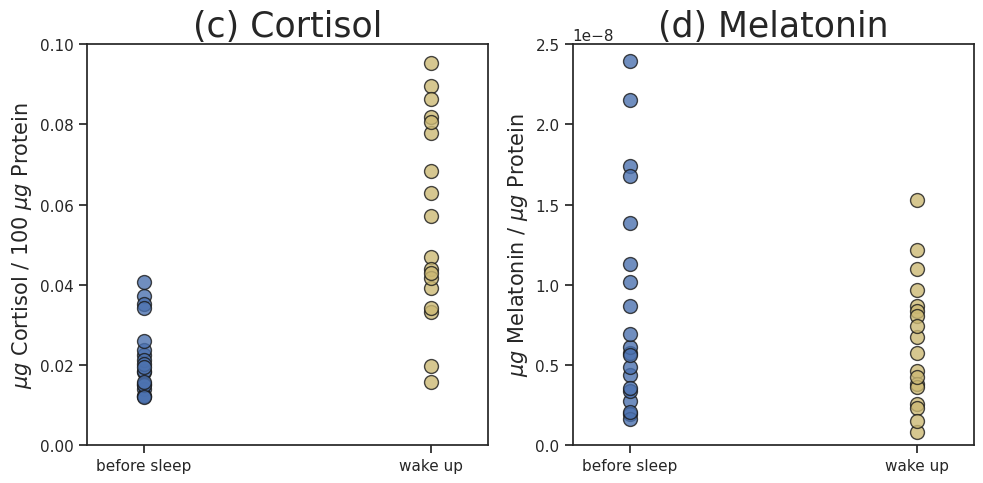

In [34]:
# Line plot of Cortisol and Melatonin concentrations obtained from saliva sample. Differencebetween “before sleep” and “wake up” hormones concentration

f,ax = plt.subplots(1,2,figsize=(10,5))
for w,c in zip(['before sleep','wake up'],['b','y']):
    df_w = df_saliva[df_saliva['SAMPLES']==w]
    df_w = df_w[df_w['Cortisol NORM']<0.1]
    ax[0].scatter([w]*len(df_w), df_w['Cortisol NORM'], c=c, label=w, edgecolors='k', s=100, alpha=0.8)
ax[0].set_title('(c) Cortisol',fontsize=25)
ax[0].set_ylabel('$\mu g$ Cortisol / 100 $\mu g$ Protein',fontsize=15)
ax[0].set_xlabel('')
plt.sca(ax[0])
plt.xlim(-0.2,1.2)
plt.ylim(0,0.10)

for w,c in zip(['before sleep','wake up'],['b','y']):
    df_w = df_saliva[df_saliva['SAMPLES']==w]
    df_w = df_w[df_w['Melatonin NORM']<2.5e-8]
    ax[1].scatter([w]*len(df_w), df_w['Melatonin NORM'], c=c, edgecolors='k', s=100, alpha=0.8)
ax[1].set_title('(d) Melatonin',fontsize=25)
ax[1].set_ylabel('$\mu g$ Melatonin / $\mu g$ Protein',fontsize=15)
ax[1].set_xlabel('')
plt.sca(ax[1])
plt.xlim(-0.2,1.2)
plt.ylim(0,2.5e-8)

f.tight_layout()
plt.show()

In [35]:
bisbas=df_BISBAS.to_numpy()
panas=df_PANAS.to_numpy()
actigraph=df_actigraph.to_numpy()
activity=df_activity.to_numpy()
activity_count=df_activity_count.to_numpy()
antro=df_antro.to_numpy()
circadian=df_circadian.to_numpy()
group_BISBAS=df_group_BISBAS.to_numpy()
group_Panas=df_group_Panas.to_numpy()
question=df_question.to_numpy()
rr=df_rr.to_numpy()
saliva=df_saliva.to_numpy()
sleep=df_sleep.to_numpy()
user=df_user.to_numpy()
user_example=df_user_example.to_numpy()
w=df_w.to_numpy()
window=df_window.to_numpy()



In [40]:
salivan=df_saliva['Cortisol NORM'].to_numpy()
salivam=df_saliva['Melatonin NORM'].to_numpy()
print(salivam)
l=np.size(salivan)
cortisol_change=[]
melatonin_b=[]
melatonin_a=[]
for i in range(math.floor(l/2)):
 cortisol_change.append(salivan[i*2+1]-salivan[i*2])
 melatonin_b.append(salivam[i*2])
 melatonin_a.append(salivam[i*2+1])
print(cortisol_change)
print(melatonin_b)
print(melatonin_a)
y=question[1:,3]
print(np.size(cortisol_change))
y_m=np.mean(y)
y_sigma=np.std(y)
c_m=np.mean(cortisol_change)
c_sigma=np.std(cortisol_change)
yn=(y-y_m)/y_sigma
cn=(cortisol_change-c_m)/c_sigma
cortisolcorpsqi=np.corrcoef(cn,yn)
melatoninbcorpsqi=np.corrcoef(melatonin_b,y3)
melatoninacorpsqi=np.corrcoef(melatonin_a,y3)
print(melatoninbcorpsqi)
print(melatoninacorpsqi)



[4.37933056e-09 1.52994862e-08 2.72819855e-09 8.28380171e-10
 4.88548283e-09 4.63853361e-09 8.66961066e-09 2.57379507e-09
 2.39623888e-08 1.09677718e-08 1.38466061e-08 5.73051208e-09
 1.90226813e-09 2.29593262e-09 3.33448211e-09 3.82031033e-09
 3.54280384e-09 8.63998757e-09 5.71443888e-09 3.60332418e-09
 1.12600937e-08 8.36317942e-09 6.11097348e-09 4.25557890e-09
 1.73838453e-08 6.74789302e-09 1.62990708e-09 1.49565283e-09
 2.14974692e-08 8.05560955e-09 5.59334188e-09 7.38599211e-09
 1.67634185e-08 2.85390492e-08 1.01615379e-08 1.21739719e-08
 6.92359042e-09            nan 2.03807665e-09 9.65347593e-09]
[0.07696576023504309, 0.0148358690951516, 0.0331866691931744, -0.0173871397726735, 0.067206129629227, 0.053327950003854305, 0.021912682120231702, 0.0513311269746699, -0.010345904776472709, 0.0316572747563497, 0.0668494174012451, 0.0234469188250345, 0.0438020728381615, 0.0508743408897019, 0.0179524268359005, 0.05459177741130831, 0.2400654797345978, 0.0368683790214868, 0.0234849519428287,

In [37]:
y=df_question['Pittsburgh'].to_numpy()
print(df_question['Pittsburgh'])
p=np.size(y)
y1=[]
print(y)
#
for j in range(p):
  if y[j]<6:
    y1.append(1)
  else:
    y1.append(0)

print(y1)


user
user_17    3.0
user_22    5.0
user_21    4.0
user_20    5.0
user_10    4.0
user_5     8.0
user_18    5.0
user_13    4.0
user_8     3.0
user_12    4.0
user_3     8.0
user_6     9.0
user_14    2.0
user_1     5.0
user_19    4.0
user_4     4.0
user_9     9.0
user_2     7.0
user_7     7.0
user_16    5.0
user_11    7.0
Name: Pittsburgh, dtype: float64
[3. 5. 4. 5. 4. 8. 5. 4. 3. 4. 8. 9. 2. 5. 4. 4. 9. 7. 7. 5. 7.]
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]


In [38]:
eff=df_sleep['Efficiency'].to_numpy()
y=df_question['Pittsburgh'].to_numpy()
#effcorpsqi=np.corrcoef(eff,np.array(y1))
effcorpsqi=np.corrcoef(eff,np.array(y))
print(effcorpsqi)


[[ 1.         -0.15842263]
 [-0.15842263  1.        ]]


In [39]:
salivan=df_saliva['Cortisol NORM'].to_numpy()
salivam=df_saliva['Melatonin NORM'].to_numpy()
print(df_saliva['Cortisol NORM'])
y2=np.array(y1)
print(y2)
y3=np.concatenate([y2[0:2],y2[3:]])

user
user_17    0.018304
user_17    0.095269
user_22    0.018414
user_22    0.033249
user_20    0.013820
user_20    0.047007
user_10    0.037046
user_10    0.019659
user_5     0.022310
user_5     0.089516
user_18    0.015166
user_18    0.068494
user_13    0.012278
user_13    0.034191
user_8     0.035106
user_8     0.086437
user_12    0.155777
user_12    0.145431
user_3     0.012142
user_3     0.043799
user_6     0.015039
user_6     0.081888
user_14    0.015788
user_14    0.039235
user_1     0.034137
user_1     0.077939
user_19    0.012017
user_19    0.062891
user_4     0.023772
user_4     0.041724
user_9     0.025968
user_9     0.080560
user_2     0.021186
user_2     0.261252
user_7     0.020206
user_7     0.057075
user_16    0.019456
user_16    0.042941
user_11    0.040592
user_11    0.015572
Name: Cortisol NORM, dtype: float64
[1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0]


In [43]:
meq=df_question['MEQ'].to_numpy()
sta1=df_question['STAI1'].to_numpy()
sta2=df_question['STAI2'].to_numpy()
ds=df_question['Daily_stress'].to_numpy()
bis=df_question['BISBAS_bis'].to_numpy()
bisre=df_question['BISBAS_reward'].to_numpy()
bisde=df_question['BISBAS_drive'].to_numpy()
bisfun=df_question['BISBAS_fun'].to_numpy()
print(bisfun)
meqcorpsqi=np.corrcoef(meq,y1)
sta1corpsqi=np.corrcoef(sta1,y1)
sta2corpsqi=np.corrcoef(sta2,y1)
dscorpsqi=np.corrcoef(ds,y1)
biscorpsqi=np.corrcoef(bis,y1)
bisrecorpsqi=np.corrcoef(bisre,y1)
bisdecorpsqi=np.corrcoef(bisde,y1)
bisfuncorpsqi=np.corrcoef(bisde,y1)
print(meqcorpsqi)
corr, _ = stats.pearsonr(bis,y1)
print(sta1corpsqi)
print(sta2corpsqi)
print(dscorpsqi)
print(biscorpsqi)
print(bisrecorpsqi)
print(bisdecorpsqi)
print(bisfuncorpsqi)

[13. 11.  7.  9. 14. 15. 11. 12.  9.  8.  6. 15.  5. 14. 11. 14. 10.  6.
  6. 13. 13.]
[[1.         0.15813705]
 [0.15813705 1.        ]]
[[1.         0.02699091]
 [0.02699091 1.        ]]
[[nan nan]
 [nan  1.]]
[[ 1.         -0.11579149]
 [-0.11579149  1.        ]]
[[1.         0.18370086]
 [0.18370086 1.        ]]
[[ 1.         -0.08585457]
 [-0.08585457  1.        ]]
[[ 1.         -0.19605383]
 [-0.19605383  1.        ]]
[[ 1.         -0.19605383]
 [-0.19605383  1.        ]]


In [44]:
HR=df_actigraph['HR'].to_numpy()
start=df_sleep['In Bed Time'].to_numpy()
end=df_sleep['Out Bed Time'].to_numpy()
time=df_actigraph['time'].to_numpy()
print(df_question['Pittsburgh'])
sum=0
p=0
lis=[]
for j in range(np.size(start)):
    datetime_object1 = datetime.strptime(start[j],'%H:%M')
    datetime_object2 = datetime.strptime(end[j],'%H:%M')
    for i in range(np.size(time)):
       datetime_object = datetime.strptime(time[i],'%H:%M:%S')

       if datetime_object>datetime_object1 and datetime_object<datetime_object2:
          sum=sum+HR[i]
          p=p+1

    mean=sum/p
    lis.append(mean)






user
user_17    3.0
user_22    5.0
user_21    4.0
user_20    5.0
user_10    4.0
user_5     8.0
user_18    5.0
user_13    4.0
user_8     3.0
user_12    4.0
user_3     8.0
user_6     9.0
user_14    2.0
user_1     5.0
user_19    4.0
user_4     4.0
user_9     9.0
user_2     7.0
user_7     7.0
user_16    5.0
user_11    7.0
Name: Pittsburgh, dtype: float64


In [45]:
print(lis)

[60.65479934965279, 60.668672055583954, 60.54355712918945, 61.28234518673303, 61.49910564750878, 61.49910564750878, 61.35276342865896, 61.35276342865896, 61.384650740903645, 61.32954411617485, 61.32954411617485, 61.73385021229654, 61.71845033268481, 61.73358819578622, 61.68136761933174, 61.68136761933174, 61.60827639927324, 62.406430228857495, 62.29659207971888, 62.3284835823256, 62.353748286201515]


In [47]:
datetime_str='09:26:11'
datetime_str1='01:36:11'
datetime_object = datetime.strptime(start[1],'%H:%M')
datetime_object1 = datetime.strptime(time[2],'%H:%M:%S')
datetime_object
print(datetime_object)
print(datetime_object1)
print(datetime_object>datetime_object1)
hrcorpsqi=np.corrcoef(lis,y1)
print(hrcorpsqi)





1900-01-01 01:06:00
1900-01-01 09:26:12
False
[[ 1.         -0.47460095]
 [-0.47460095  1.        ]]


In [68]:
age=df_antro['Age'].to_numpy()
agecorpsqi=np.corrcoef(age,y1)
print(agecorpsqi)
lis1=np.array(lis)

hrcorcortisol_change=np.corrcoef(cortisol_change,lis2)
print(hrcorcortisol_change)


[[nan nan]
 [nan  1.]]
[[1.         0.21635645]
 [0.21635645 1.        ]]


[60.65479935 60.66867206 61.28234519 61.49910565 61.49910565 61.35276343
 61.35276343 61.38465074 61.32954412 61.32954412 61.73385021 61.71845033
 61.7335882  61.68136762 61.68136762 61.6082764  62.40643023 62.29659208
 62.32848358 62.35374829]
[60.65479935 60.66867206 60.54355713 61.28234519 61.49910565 61.49910565
 61.35276343 61.35276343 61.38465074 61.32954412 61.32954412 61.73385021
 61.71845033 61.7335882  61.68136762 61.68136762 61.6082764  62.40643023
 62.29659208 62.32848358 62.35374829]


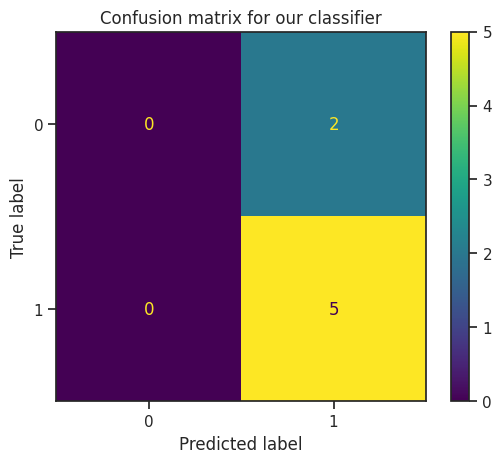

In [91]:
lis2=[]
xp = [[0 for i in range(2)] for j in range(np.size(lis1))]
lis2=np.concatenate((lis1[0:2],lis[3:]))
print(lis2)
print(lis1)
for i in range(np.size(lis1)):
  xp[i][0]=lis[i]
  xp[i][1]=0

X_train, X_test, y_train, y_test = train_test_split(xp,y2,test_size=0.3)
clf = svm.SVC(kernel='linear')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm =confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=clf.classes_)
disp.plot()
plt.title('Confusion matrix for our classifier')
plt.show()


In [93]:
accuracy_score(y_test,predictions)

0.7142857142857143